# Testing our formulation of the stress intensity factor against examples from the literature

We've selected two areas from two studies to test the stress intensity factor computation using the derived local stress fields. For each "crack", we

1. Sample the points along the crack from the stress grids to construct the stress tensors
1. Integrate stress tensor for each point over plate thickness
2. Rotate the stress tensors into a ridge-normal/ridge-parallel coordinate system
3. Extract the ridge-normal stresses that "load" the crack
4. Integrate the crack loading along the ridge to compute the stress intensity factor

$$
K_I = \frac{1}{H\left(a\pi\right)^{1/2}}\int_{-a}^{a} p\left(x\right) \left(\frac{a+x}{a - x}\right)^{1/2}\, dx
$$

In [1]:
import numpy as np
import math
import os
import pygmt
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('./src')
from ridgetools import *

In [11]:
from topo_stress import topo_stress_grd

def run_topo_stress(topofile):
    depths = [-0.5,-1.5,-2.5,-3.5,-4.5,-5.5,-6.5]
    for depth in depths:
        Txx, Tyy, Tzz, Txy, Txz, Tyz, lon, lat = topo_stress_grd(topofile,depth)
        for grid,name in zip([Txx.real, Tyy.real, Tzz.real, Txy.real, Txz.real, Tyz.real],
                             ['Txx','Tyy','Tzz','Txy','Txz','Tyz']):
            write_GMT_netcdf('{}.{}.nc'.format(name,str(depth)),lon,lat,grid)
    return

def get_stresses_one_model(gridDir,ridgeFile):
    filename = os.getcwd() + "/segments/Test/{}.txt".format(ridgeFile)
    myRidge = load_one_ridge(filename)
    depths = [-0.5,-1.5,-2.5,-3.5,-4.5,-5.5,-6.5]
    stresses = ['Txx','Tyy','Tzz','Txy','Txz','Tyz']
    for depth in depths:
        for stress in stresses:
            gridFileName = gridDir + stress + '.' + str(depth) + '.nc'
            myRidge = sample_ridge_on_grid(myRidge,gridFileName)    
    return myRidge

def get_crack_load_one_model(ridgeFile):
    myRidge = load_ridge_csv(ridgeFile)
    n = myRidge.shape[0]
    ridgeAzi = get_ridge_azimuth(myRidge)
    ridgeLoading = np.zeros((n,))

    for ii in range(0,n):
        onePoint = myRidge.iloc[ii,:]
        ridgeLoading[ii] = get_loading_stress(onePoint,ridgeAzi)
    x = lonlat2x(myRidge)
    return x, ridgeLoading

In [3]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.02.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_02
!mv T*.nc stress_grds/west_96E.save/extended_filt_02/.

In [4]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.10.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_10
!mv T*.nc stress_grds/west_96E.save/extended_filt_10/.

In [5]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.20.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_20
!mv T*.nc stress_grds/west_96E.save/extended_filt_20/.

In [6]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.30.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_30
!mv T*.nc stress_grds/west_96E.save/extended_filt_30/.

In [7]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.40.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_40
!mv T*.nc stress_grds/west_96E.save/extended_filt_40/.

In [8]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.50.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_50
!mv T*.nc stress_grds/west_96E.save/extended_filt_50/.

In [9]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.60.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_60
!mv T*.nc stress_grds/west_96E.save/extended_filt_60/.

In [10]:
eqrocktopo='/Users/huharper/03_topo-stress/west_96E.save/topo.eqrk.70.nc'
run_topo_stress(eqrocktopo)
!mkdir stress_grds/west_96E.save/extended_filt_70
!mv T*.nc stress_grds/west_96E.save/extended_filt_70/.

---

# Loading a ridge segment and getting all stress components

The local and regional stresses for the study area were generated in the previous steps and saved as nc grids. The following routine samples along a track from all of those grids and outputs a csv data table which can (and should) be saved for loading later.

In [13]:
gridDirPrefix = 'stress_grds/west_96E.save/'
filt_list = ['02','10','20','30','40','50','60','70']
gridDirList = ['extended_filt_{}/'.format(i) for i in filt_list]

for grid in gridDirList:
    gridDir = gridDirPrefix + grid
    gRidgePR = get_stresses_one_model(gridDir,"96E-PR")
    gRidgeFR = get_stresses_one_model(gridDir,"96E-FR")
    gRidgePR.to_csv(gridDir + '96E-PR.txt')
    gRidgeFR.to_csv(gridDir + '96E-FR.txt')

## Get the loading stress for a crack
**TODO: clean all this up...**

All the data is stored in the galapagos-west pandas dataframe. The following block will get the loading stress at each sampled point.

In [23]:
gridDirPrefix = 'stress_grds/west_96E.save/'
filt_list = ['02','10','20','30','40','50','60','70']
gridDirList = ['extended_filt_{}/'.format(i) for i in filt_list]

print('{:20s}, {:10s}, {:10s}, {:10s}'.format('model','K_PR Pa m^(1/2)','K_FR Pa m^(1/2)', '% Difference'))
for grid in gridDirList:
    myFilePR = gridDirPrefix + grid + '96E-PR.txt'
    x, ridgeLoadingFullPR = get_crack_load_one_model(myFilePR)
    K_PR = compute_K(x,ridgeLoadingFullPR)
    myFileFR = gridDirPrefix + grid + '96E-FR.txt'
    x, ridgeLoadingFullFR = get_crack_load_one_model(myFileFR)
    K_FR = compute_K(x,ridgeLoadingFullFR)
    print('{:20s},  {:7e},   {:7e},  {:.1f}'.format(grid,K_PR,K_FR,100*(K_PR-K_FR)/abs(K_PR)))

model               , K_PR Pa m^(1/2), K_FR Pa m^(1/2), % Difference
extended_filt_02/   ,  -1.509142e+09,   -1.171880e+09,  -22.3
extended_filt_10/   ,  -1.410397e+09,   -9.723623e+08,  -31.1
extended_filt_20/   ,  -8.557868e+08,   -6.308392e+08,  -26.3
extended_filt_30/   ,  -9.295921e+08,   -7.074548e+08,  -23.9
extended_filt_40/   ,  -8.147667e+08,   -5.422423e+08,  -33.4
extended_filt_50/   ,  -6.918711e+08,   -5.241932e+08,  -24.2
extended_filt_60/   ,  -7.367996e+08,   -4.644642e+08,  -37.0
extended_filt_70/   ,  -5.284410e+08,   -3.593319e+08,  -32.0


In this case, we are comparing the stress intensity factor for a propagating ridge and for a failing ridge. We hypothesize that the stress intensity factor of a propagating ridge should exceed the stress intensity factor of a failing ridge, and the difference shown should be positive. We also hypothesize that the difference should be insensitive to the filter chosen. What do we see? Regardless of the model we use, the sign of the difference is negative, i.e., the opposite of what we expect. However, the difference doesn't vary too much.

---

## An alternative loading function
The two papers mentioned earlier use an alternative loading function based only on the depth relative to the surrounding seafloor.

In [27]:
rho_l = 2900 # density of lithosphere
rho_w = 1035 # density of water
g = 9.8 #
H = 7e3 # plate thickness, m

deps = pygmt.grdtrack(galaRidge.iloc[:,0:2],'/Users/huharper/03_topo-stress/galapagos.topo.nc',newcolname='depth')
deps = deps.iloc[:,-1]
deps = deps + 2400 # this is an ad hoc depth for the Galapagos ridge
altRidgeLoading = (rho_l - rho_w)*g*deps*H/2
KAlt = compute_K(x,altRidgeLoading)
print('K = {:e} Pa m^(1/2)'.format(KAlt))

K = -3.153601e+08 Pa m^(1/2)


## Notes
~~So, as it stands, the calculation for the galapagos ridge is about two orders of magnitude less than the value given in PM & P. Why might that be?~~

~~1. Slight mismatch b/t my digitized ridge and the referenced. Their ridge extends slightly farther both east and west. However, this shouldn't make much of a difference.~~
~~2. Improper depth-averaging of the stress field~~
~~3. Improper integration scheme or limits of integration~~
~~4. others?~~

## Solution
1. p(x) is a force per unit length, not a stress. So, this should be integrated along depth instead of averaged.
2. Elastic thickness in the topo_stress routine was set to 7km, instead of the proper 0km, so some amount of the stress is due to flexure

## Plot depth profile, crack loading profiles

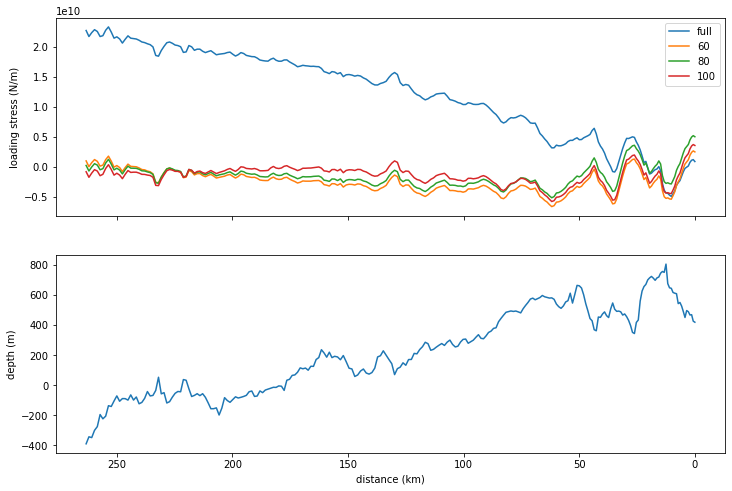

In [36]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
ax[0].plot(x*1e-3,ridgeLoadingFull,label='full')
ax[0].plot(x*1e-3,ridgeLoading60,label='60')
ax[0].plot(x*1e-3,ridgeLoading80,label='80')
ax[0].plot(x*1e-3,ridgeLoading100,label='100')
ax[0].set_ylabel('loading stress (N/m)')
ax[0].legend()
ax[1].plot(x*1e-3,deps)
ax[1].set_ylabel('depth (m)')
ax[1].set_xlabel('distance (km)')
ax[0].invert_xaxis()

This is essentially the result from PM & P, except they completely linearized the topography, so there's no short wavelength variations, just a line trending down. Our result for K is on the same order of magnitude.

### Needed:
Some sanity checks. For instance, print out the ridge azimuth, length, etc...
A driver function so I can just give a file/ridge name and not copy/paste over n over

# More demos
## Larger grdcut area
I was using a region of -R-98/-86/-3/7 in the previous models. What's the difference when I use a larger area (-R-115/-85/-7/12)?

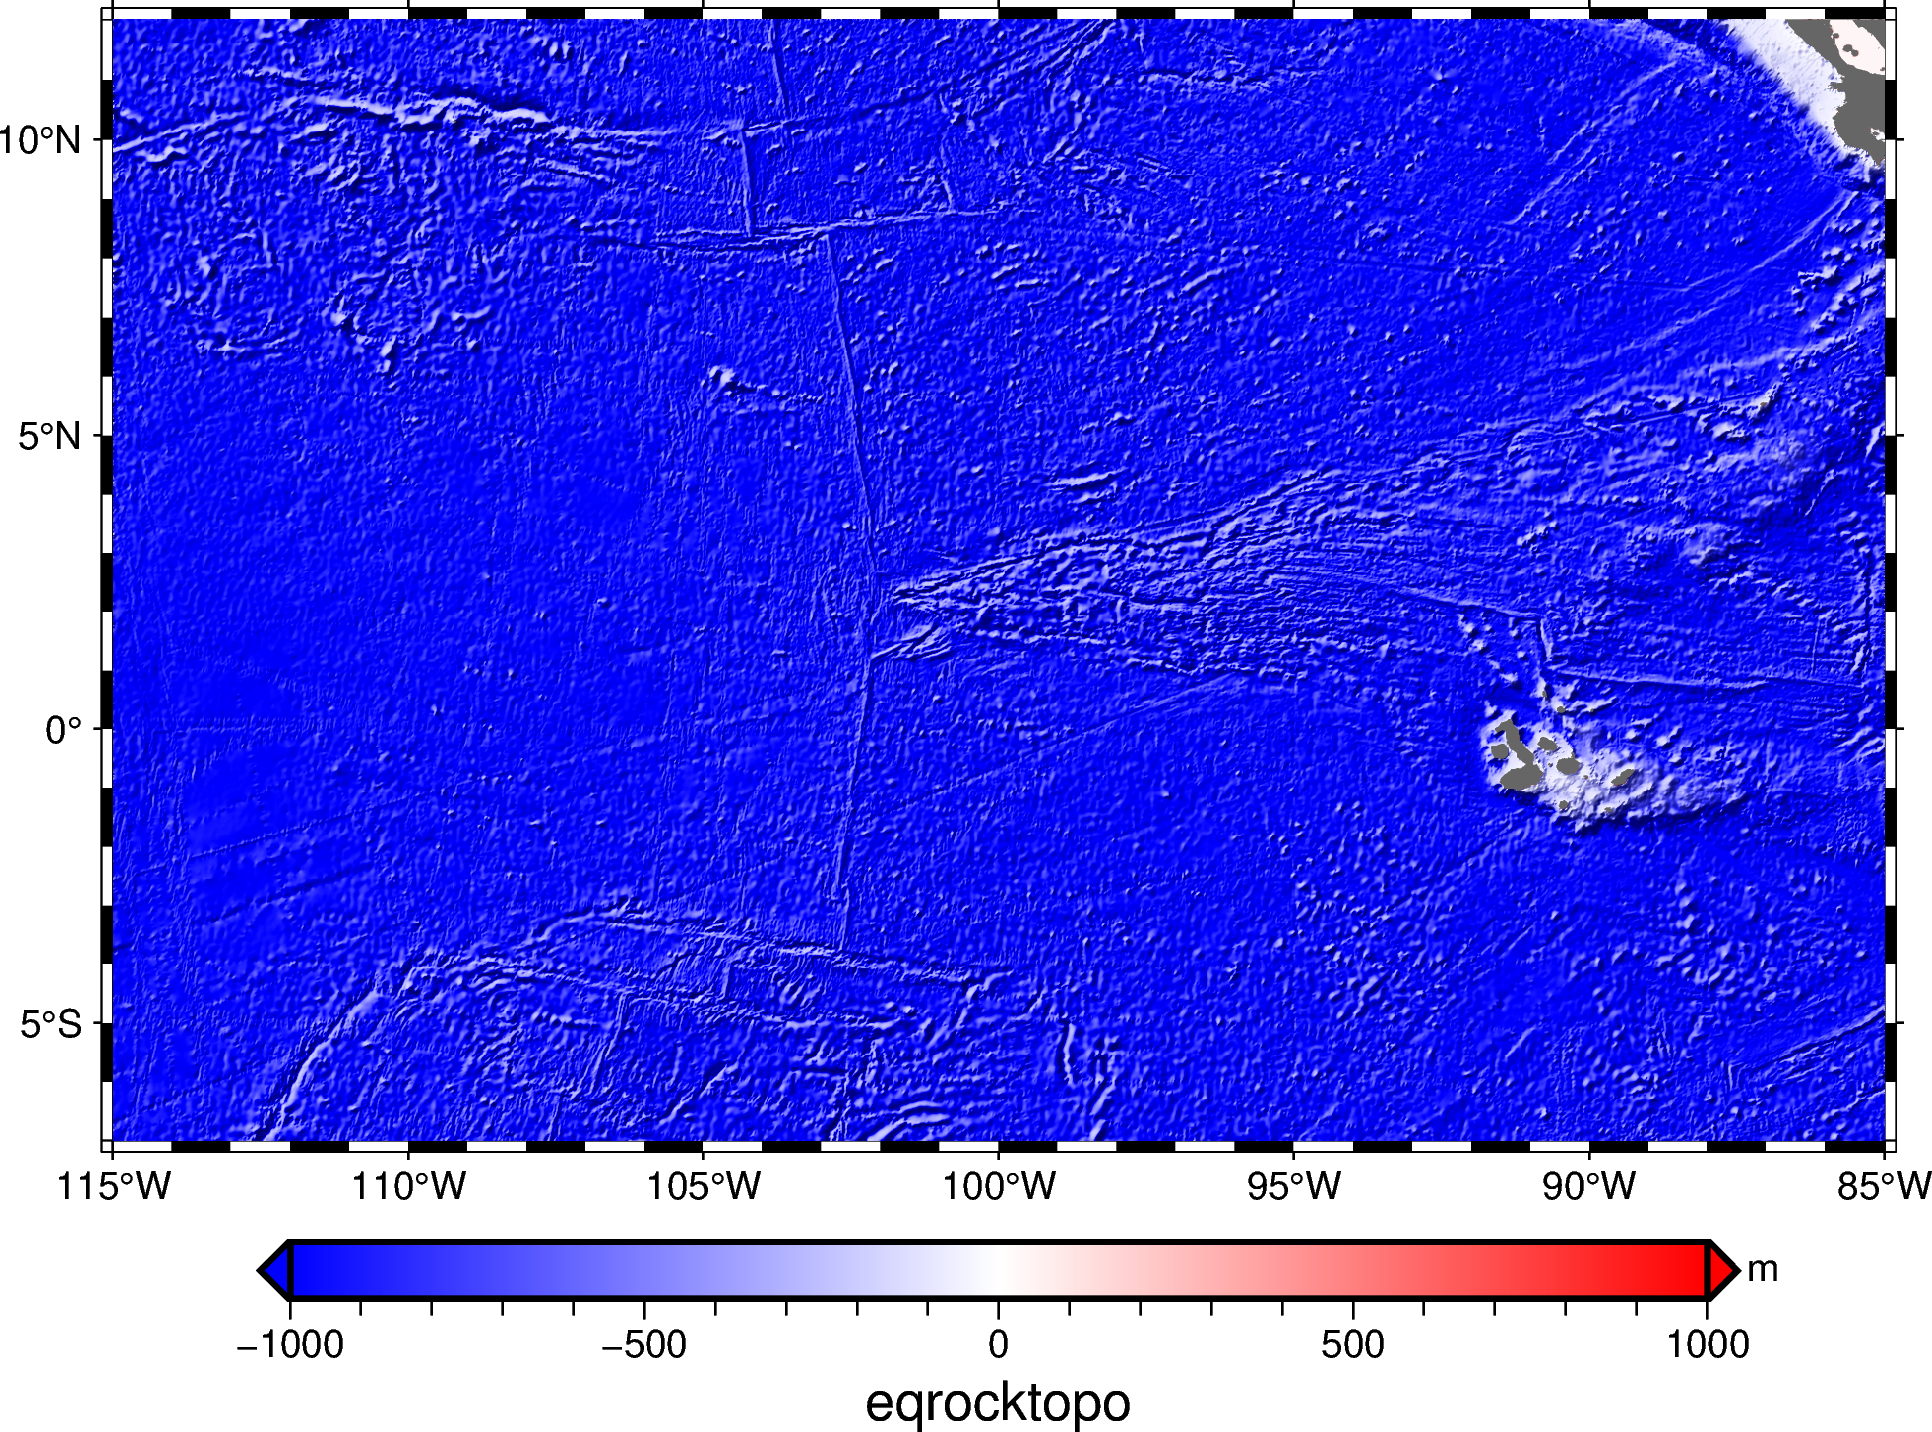

In [42]:
region = [-115, -85, -7, 12]
grid = '/Users/huharper/03_topo-stress/galapagos.extended.nc'

gmt_fig = gmt_gridplot(region,grid)
gmt_fig.colorbar(
    position='+e',
    frame=['x+leqrocktopo','y+lm']
)
gmt_fig.show()

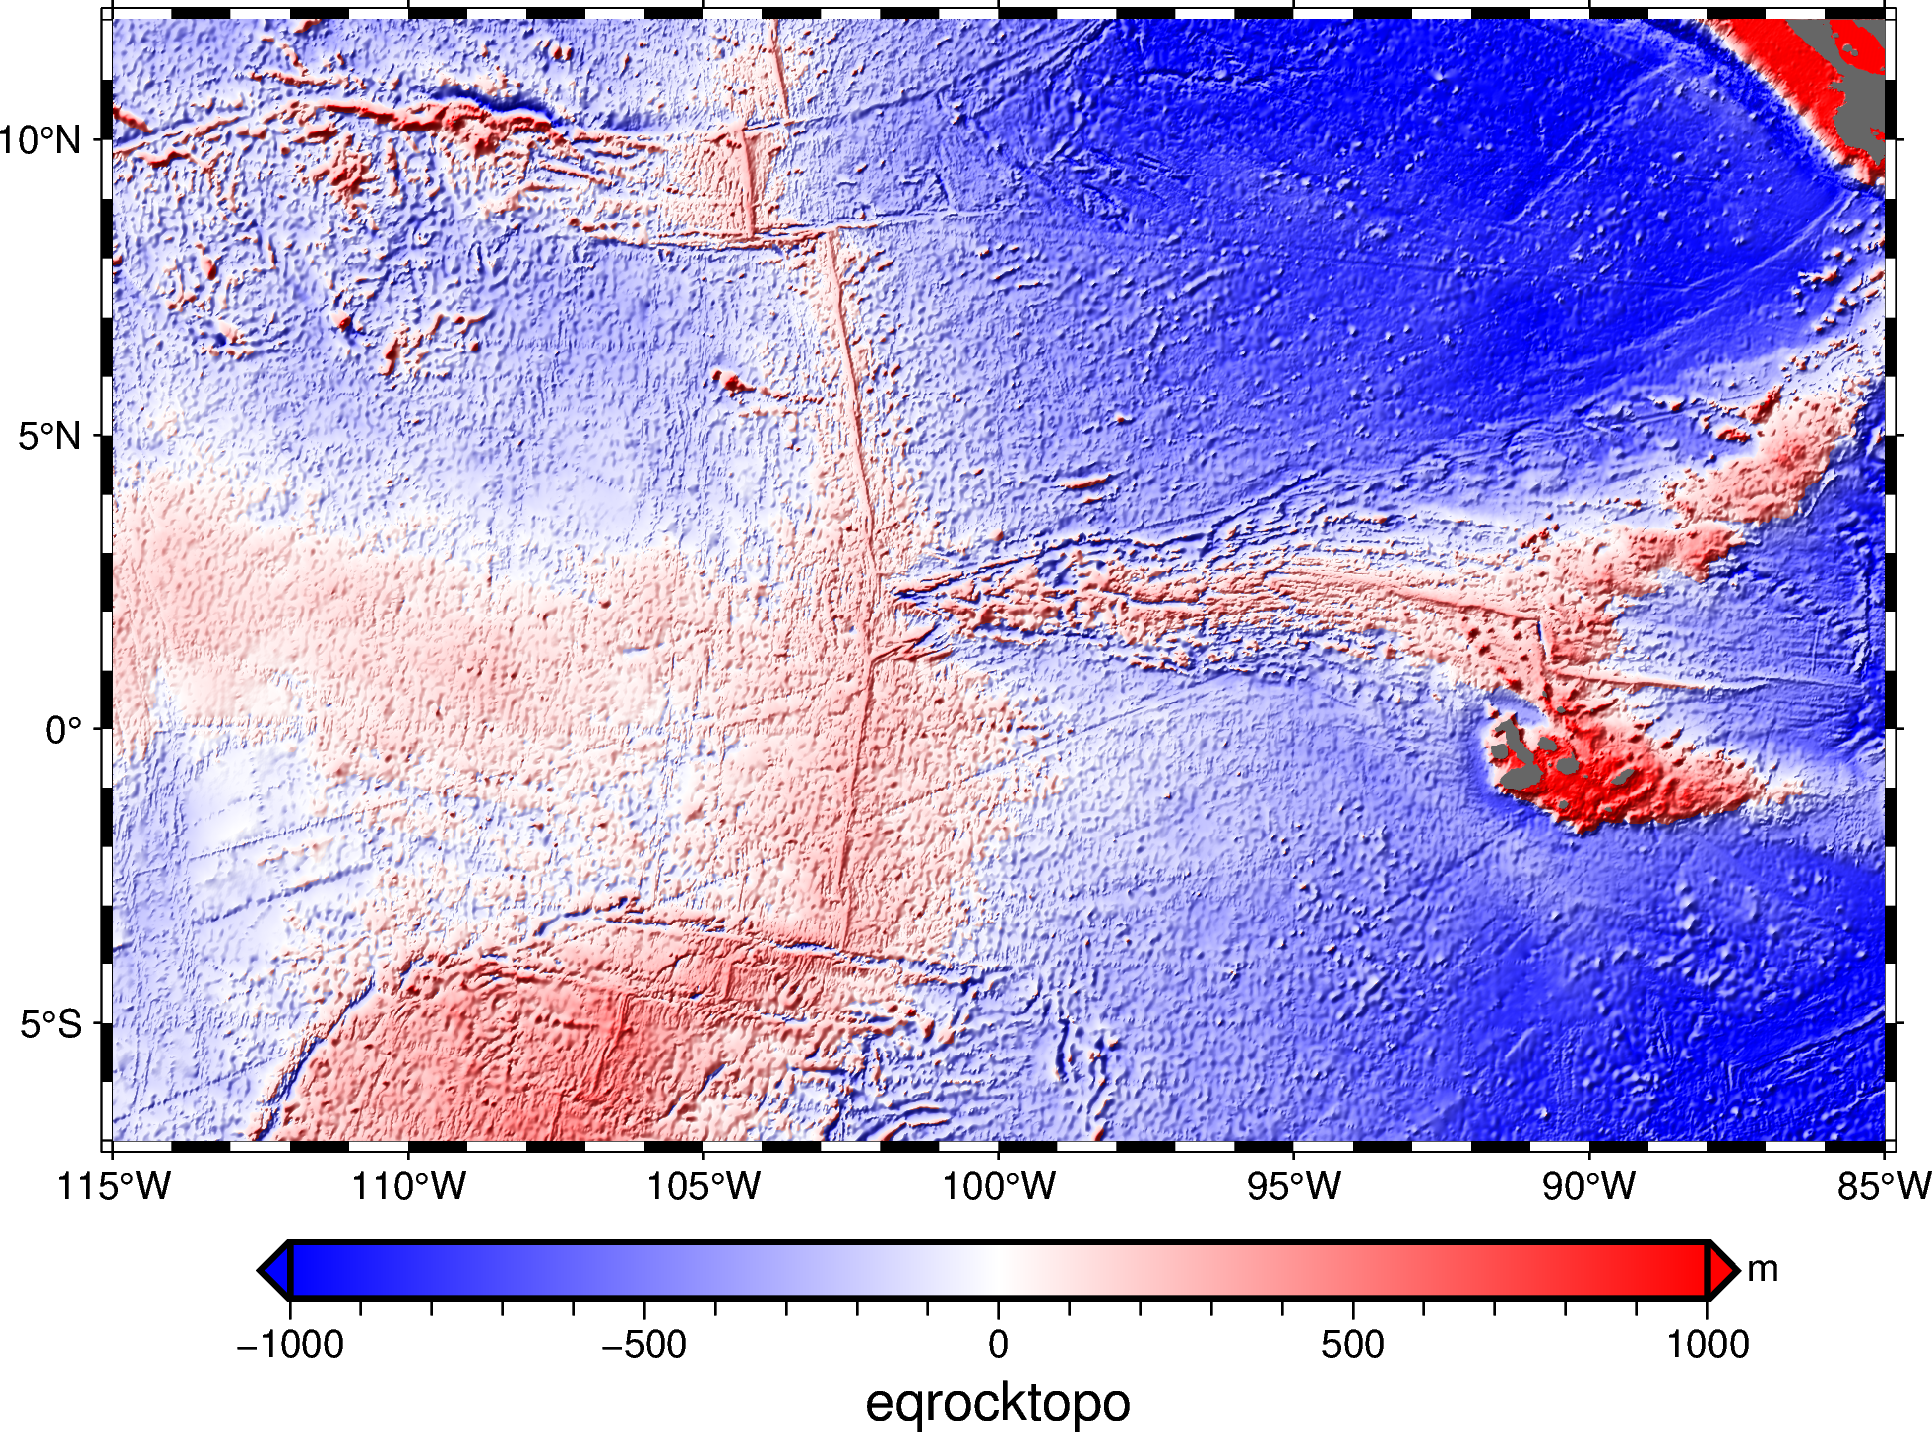

In [8]:
region = [-115, -85, -7, 12]
grid = '/Users/huharper/03_topo-stress/galapagos.extended.1.10.nc'

gmt_fig = gmt_gridplot(region,grid)
gmt_fig.colorbar(
    position='+e',
    frame=['x+leqrocktopo','y+lm']
)
gmt_fig.show()